# Modeling the Hourly Rate

This code trains a model to predict what a prospective freelancers hourly rate should be. The model used is a random forest regression model. I also built an AdaBoosted Decision Tree model, but it performs much worse (using 5-fold cross-validation) compared with the turned random forest regression model.

I've also built a k-modes (cluster with categorical/numeric mixed data) model. It is currently being tested.

# Prep

## Importing Libraries and Data

In [2]:
# Data Analysis and Modeling
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import time

# Random Forest Regression
from sklearn.ensemble import RandomForestRegressor

# AdaBoost Decision Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# LASSO
from sklearn.linear_model import LassoCV, Lasso

# XGBoost
import xgboost as xgb

# Cross-Validation and Accuracy Measures
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

# Model Serializing (export to web-app)
import pickle

# Packages for PostgreSQL Import
import psycopg2
import os

# Packages for K-Modes Cluster
from kmodes.kmodes import KModes

## Importing Data from SQL

In [3]:
# Names for accessing SQL database
dbname = "freelance_db"
username = os.environ['USER']
pswd = os.environ['SQLPSWD']

# Connect to SQL Database
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# Importing Data
sql_query = """SELECT * FROM analysis_dummies_table;"""
analysis_dt = pd.read_sql_query(sql_query, con)

sql_query = """SELECT * FROM embeddings_table;"""
embeddings = pd.read_sql_query(sql_query, con)

# Doing some cleaning. Removing columns that have a continuous analog in the model.
analysis_dt = analysis_dt.drop(['index'], axis=1)
analysis_dt = analysis_dt.drop(['first_skill'], axis = 1)

# Removing index col from embeddings
embeddings = embeddings.drop(['index'], axis = 1)
embeddings['profile_url'] = "https://www.guru.com" + embeddings['profile_url']

# Merging on profile_url
analysis_dt = analysis_dt.merge(embeddings, how = "left", 
                                left_on = "profile_url", right_on= "profile_url")
analysis_dt = analysis_dt.drop(['profile_url'], axis = 1)
analysis_dt = analysis_dt.fillna(0)

# Cleaning avg_word_length and bio_word count
analysis_dt.loc[analysis_dt['bio_length'] == 0, ['bio_word_count','avg_word_length']] = 0

# Removing inactive users
analysis_dt = analysis_dt.loc[analysis_dt['has_quote'] == 1, :]
analysis_dt.shape

# Removing crazy outliers
analysis_dt = analysis_dt.loc[analysis_dt['hourly_rate'] < 100, :]

# Final Cleaning
analysis_dt = analysis_dt.drop(['num_skills','earnings_per_month',
                                'hours_worked', 'worked_pst_yr',
                                'hours_worked_pr_mnth','has_quote'], axis = 1)
analysis_dt = analysis_dt.drop(analysis_dt.columns[15:65], axis = 1)

# Last check
analysis_dt.shape

(374, 65)

In [4]:
cols = analysis_dt.columns
display(cols)

Index(['hourly_rate', 'bio_length', 'bio_word_count', 'avg_word_length',
       'num_stop', 'administrative & secretarial', 'business & finance',
       'design & art', 'education & training', 'engineering & architecture',
       'legal', 'programming & development', 'sales & marketing',
       'writing & translation', 'hours_worked_pr_mnth_pst_yr', '0', '1', '2',
       '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15',
       '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27',
       '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39',
       '40', '41', '42', '43', '44', '45', '46', '47', '48', '49'],
      dtype='object')

## Prepping Data for Training

In [5]:
# Converting data to numpy arrays and saving column names
y = np.array(analysis_dt['hourly_rate'])

analysis_dt = analysis_dt.drop(['hourly_rate'], axis = 1)
feature_list = list(analysis_dt.columns)

X = np.array(analysis_dt)

In [6]:
# Creating train and test splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

# Modeling - XGBoost

In [7]:
# Convert Data into DMatrix
dtest = xgb.DMatrix(X_test, label=y_test)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.save_binary((os.environ['PWD'] + '/data/cleaned/train.buffer'))
dtest.save_binary((os.environ['PWD'] + '/data/cleaned/test.buffer'))

In [8]:
# Baseline Model without Tuning
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric': "mae"
}

num_boost_round = 999

# Cross-Validated XGBoost
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

# MAE With Default Params = 12.26

[0]	Test-mae:17.15086
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:13.44994
[2]	Test-mae:12.58369
[3]	Test-mae:12.61564
[4]	Test-mae:12.43206
[5]	Test-mae:12.30434
[6]	Test-mae:12.26478
[7]	Test-mae:12.42656
[8]	Test-mae:12.61485
[9]	Test-mae:12.64262
[10]	Test-mae:12.72911
[11]	Test-mae:12.79451
[12]	Test-mae:12.87032
[13]	Test-mae:12.93030
[14]	Test-mae:12.96977
[15]	Test-mae:12.93859
[16]	Test-mae:13.00486
Stopping. Best iteration:
[6]	Test-mae:12.26478



In [11]:
# Reference: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(2, 20, 2)
    for min_child_weight in range(2, 20, 2)
]

min_mae = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
        max_depth,
        min_child_weight))    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best MAE
    
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth, min_child_weight)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=2, min_child_weight=2
	MAE 14.521995399999998 for 6 rounds
CV with max_depth=2, min_child_weight=4
	MAE 14.487337 for 5 rounds
CV with max_depth=2, min_child_weight=6
	MAE 14.4810192 for 6 rounds
CV with max_depth=2, min_child_weight=8
	MAE 14.470600200000002 for 5 rounds
CV with max_depth=2, min_child_weight=10
	MAE 14.4112098 for 6 rounds
CV with max_depth=2, min_child_weight=12
	MAE 14.384578999999999 for 5 rounds
CV with max_depth=2, min_child_weight=14
	MAE 14.419303600000001 for 6 rounds
CV with max_depth=2, min_child_weight=16
	MAE 14.408447 for 5 rounds
CV with max_depth=2, min_child_weight=18
	MAE 14.399361199999998 for 5 rounds
CV with max_depth=4, min_child_weight=2
	MAE 15.000354400000003 for 4 rounds
CV with max_depth=4, min_child_weight=4
	MAE 14.725643999999999 for 4 rounds
CV with max_depth=4, min_child_weight=6
	MAE 14.831692799999999 for 5 rounds
CV with max_depth=4, min_child_weight=8
	MAE 14.682585800000002 for 4 rounds
CV with max_depth=4, min_chi

In [12]:
# Updating params dictionary with selected values
params['max_depth'] = 12
params['min_child_weight'] = 12

In [13]:
# Tuning subsample and colsample_bytree
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,11)]
    for colsample in [i/10. for i in range(1,11)]
]

min_mae = float("Inf")
best_params = None# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
        
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

CV with subsample=1.0, colsample=1.0
	MAE 14.3170094 for 5 rounds
CV with subsample=1.0, colsample=0.9
	MAE 14.823176 for 4 rounds
CV with subsample=1.0, colsample=0.8
	MAE 14.790761800000002 for 4 rounds
CV with subsample=1.0, colsample=0.7
	MAE 15.2768372 for 5 rounds
CV with subsample=1.0, colsample=0.6
	MAE 14.923036000000002 for 4 rounds
CV with subsample=1.0, colsample=0.5
	MAE 15.237611800000002 for 4 rounds
CV with subsample=1.0, colsample=0.4
	MAE 15.3057534 for 4 rounds
CV with subsample=1.0, colsample=0.3
	MAE 15.2022008 for 5 rounds
CV with subsample=1.0, colsample=0.2
	MAE 15.1386506 for 5 rounds
CV with subsample=1.0, colsample=0.1
	MAE 15.460079400000001 for 5 rounds
CV with subsample=0.9, colsample=1.0
	MAE 14.497732200000002 for 4 rounds
CV with subsample=0.9, colsample=0.9
	MAE 14.806815599999998 for 4 rounds
CV with subsample=0.9, colsample=0.8
	MAE 14.559949 for 5 rounds
CV with subsample=0.9, colsample=0.7
	MAE 14.5359238 for 5 rounds
CV with subsample=0.9, colsamp

In [14]:
# Tuning ETA (learning rate)
min_mae = float("Inf")
best_params = None

for eta in [.3, .2, .1, .07, .05, .02, .01, .005]:
    print("CV with eta={}".format(eta))    # We update our parameters
    params['eta'] = eta    # Run and time CV
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics=['mae'],
        early_stopping_rounds=10
    )    # Update best score
    
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta

print("Best params: {}, MAE: {}".format(best_params, min_mae))

params['eta'] = best_params

CV with eta=0.3
	MAE 14.3170094 for 5 rounds

CV with eta=0.2
	MAE 14.4985594 for 7 rounds

CV with eta=0.1
	MAE 14.4261944 for 18 rounds

CV with eta=0.07
	MAE 14.417238399999999 for 24 rounds

CV with eta=0.05
	MAE 14.3815164 for 36 rounds

CV with eta=0.02
	MAE 14.433885999999998 for 86 rounds

CV with eta=0.01
	MAE 14.4032272 for 179 rounds

CV with eta=0.005
	MAE 14.445059800000001 for 355 rounds

Best params: 0.3, MAE: 14.3170094


In [15]:
# Train Final Model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-mae:16.61443
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:13.68543
[2]	Test-mae:12.58721
[3]	Test-mae:12.02043
[4]	Test-mae:11.62314
[5]	Test-mae:11.66778
[6]	Test-mae:12.05887
[7]	Test-mae:12.47646
[8]	Test-mae:12.83424
[9]	Test-mae:12.81134
[10]	Test-mae:13.00128
[11]	Test-mae:13.10092
[12]	Test-mae:13.36987
[13]	Test-mae:13.61673
[14]	Test-mae:13.70628
Stopping. Best iteration:
[4]	Test-mae:11.62314

Best MAE: 11.62 in 5 rounds


In [16]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:16.61443
[1]	Test-mae:13.68543
[2]	Test-mae:12.58721
[3]	Test-mae:12.02043
[4]	Test-mae:11.62314


In [17]:
# Exporting model
filename = os.environ['PWD'] + '/scripts/models/model_xgb_v2.model'
# filename_dump = os.environ['PWD'] + '/scripts/models/dump.raw.txt'

best_model.save_model(filename)
# best_model.dump_model(filename_dump)

# Modeling - LASSO

In [18]:
# Running model
model_lasso = LassoCV(cv=20).fit(X_train, y_train)

# Saving model with pickle
filename = os.environ['PWD'] + '/scripts/models/model_lasso.sav'
pickle.dump(model_lasso, open(filename, 'wb'))

# Modeling - Random Forest Regression
## Estimating a Random Forest Regression to Estimate Hourly-Rate

Notes:
    - Next model probability of getting a job?
    - Convert to a clustering algorithm and present a range of estimates?
    - Bootstrap to get a range of estimates?
    - Make suggestions (Increase bio length by 10 and you can charge X more)
        - "Here are bios for users similar to you" etc. etc.
    - Focus on helping users build up their profiles

In [19]:
# References for GridSearchCV
# 1 - https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters
# 2 - https://stackoverflow.com/questions/35097003/cross-validation-decision-trees-in-sklearn
# References for Random Forest Regression
# 1 - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
# 2 - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

# Creating parameter grid
parameters = {"max_features": ["auto", "sqrt"], 
              "n_estimators": [100, 500, 900, 1300, 1500], 
              "max_depth": [None,5,10,20]}

# Creating Grid Search Class
clf = GridSearchCV(RandomForestRegressor(), parameters, n_jobs=4, verbose=True, 
                   scoring="neg_mean_absolute_error",
                   refit=True, cv = 3)

# Running Grid Search
clf.fit(X=X_train, y=y_train)

# Saving best model
model_rfr = clf.best_estimator_

# Printing results
print(round(clf.best_score_,2), clf.best_params_)

# Exporting model
filename = os.environ['PWD'] + '/scripts/models/model_rfr.sav'
pickle.dump(model_rfr, open(filename, 'wb'))

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   38.0s
[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  1.6min finished


-14.58 {'max_depth': 5, 'max_features': 'auto', 'n_estimators': 1500}


# Fitting AdaBoost Model
The reason to fit this model is that iteratively re-weights observations based on how poorly the model predicts them. This pushes the model to finding a way to predict observations other models may miss. I am concerned, however, if it will overfit to outliers.

It performs poorly compared to the random forest regression.

In [20]:
# Creating parameter grid
parameters = {"n_estimators": [1, 3, 5, 10, 25, 50, 75, 100, 125, 150],
              "base_estimator__max_depth": [3, 5, 7, 9, 10, 11]}

regr_1 = DecisionTreeRegressor()
regr_2 = AdaBoostRegressor(base_estimator=regr_1)

# Creating Grid Search Class
clf = GridSearchCV(regr_2, parameters, n_jobs=4, verbose=True)

# Running Grid Search
clf.fit(X=X_train, y=y_train)

# Saving best model
model_ada = clf.best_estimator_

# Printing results
print(round(clf.best_score_, 2), clf.best_params_)

# Exporting Model
filename = os.environ['PWD'] + '/scripts/models/model_ada.sav'
pickle.dump(model_ada, open(filename, 'wb'))

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    8.4s


0.05 {'base_estimator__max_depth': 3, 'n_estimators': 3}


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   24.3s finished


# Model Evaluation

## Functions for Evaluation

In [7]:
def baseline_performance(outcome_data, test_data):
    # Assumes training the mean
    
    # Getting Baseline
    baseline_preds = np.mean(outcome_data)

    # Baseline Errors
    baseline_errors = abs(baseline_preds - test_data)

    # Baseline:
    print('Baseline Performance of Naive Mean Estimator:\nMean Absolute Error:', round(np.mean(baseline_errors), 2))
    
    return np.mean(baseline_errors)
    
def model_performance(predictions, outcome_data, baseline, model_str_name):
    # Calculate absolute error (comparison with baseline)
    errors = abs(predictions - outcome_data)
    
    print(model_str_name + ' Performance:')
    
    # Print out the mean absolute error (mae)
    print('\tMean absolute error: %.2f'
          % mean_absolute_error(outcome_data, predictions))

    # The mean squared error
    print('\tMean squared error: %.2f'
          % mean_squared_error(outcome_data, predictions))

    # The coefficient of determination (R2)
    print('\tCoefficient of determination: %.2f'
          % r2_score(outcome_data, predictions))

    # Does much better than the mean with regard to mean absolute error
    print("\tA ", round((np.mean(errors)-baseline)/baseline,3)*-100,
          "percent change over the mean")
    
    # What is the average dollar change in user hourly rate with this model?
    print("\tAverage Change in Hourly Rate vs Naive Model: $", np.mean(predictions - baseline))

def plot_preds_truth(x, y):
    # Calculate Error
    error = abs(x-y)
    
    # Plotting True Hourly Rates vs Predicted Hourly Rates
    sns.scatterplot(x = x, y = y, hue = error)
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.show()
    
# Aggregate Function: Model_performance
def model_evaluation(model, model_name_string):

    if model_name_string == 'XGBoost':
        
        # Converting data to useable format 
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        # Evaluating Model
        model_performance(model.predict(dtest), y_test, pred_baseline, 'model_name_string')

        # Plotting True Hourly Rates vs Predicted Hourly Rates
        plot_preds_truth(x = y_test, y = model.predict(dtest))
        
    else:
        
        # Evaluating Model
        model_performance(model.predict(X_test), y_test, pred_baseline, 'model_name')

        # Plotting True Hourly Rates vs Predicted Hourly Rates
        plot_preds_truth(x = y_test, y = model.predict(X_test))


## Loading Models

In [8]:
# XGBoost
model_xgboost = xgb.Booster({'nthread': 4})  # init model
model_xgboost.load_model(os.environ['PWD'] + '/scripts/models/model_xgb_v2.model')  # load data

# Lasso
filename = os.environ['PWD'] + '/scripts/models/model_lasso.sav'
model_lasso = pickle.load(open(filename, 'rb'))

# Random Forest Regression
filename = os.environ['PWD'] + '/scripts/models/model_rfr.sav'
model_rfr = pickle.load(open(filename, 'rb'))

# AdaBoost
filename = os.environ['PWD'] + '/scripts/models/model_ada.sav'
model_ada = pickle.load(open(filename, 'rb'))

## Evaluation

Baseline Performance of Naive Mean Estimator:
Mean Absolute Error: 13.73


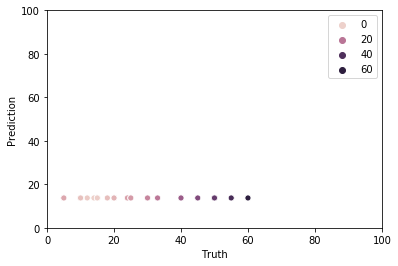

In [9]:
pred_baseline = baseline_performance(y_train, y_test)
plot_preds_truth(x = y_test, y = pred_baseline)

model_name_string Performance:
	Mean absolute error: 11.62
	Mean squared error: 203.44
	Coefficient of determination: 0.13
	A  15.299999999999999 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 11.285678


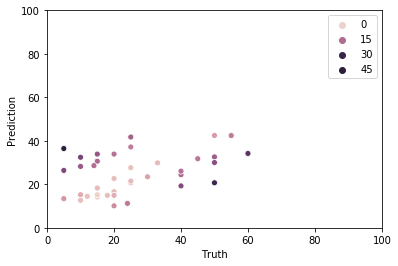

In [10]:
# XGBoost
model_evaluation(model_xgboost, 'XGBoost')

model_name Performance:
	Mean absolute error: 13.78
	Mean squared error: 371.27
	Coefficient of determination: -0.59
	A  -0.4 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 13.135606625147316


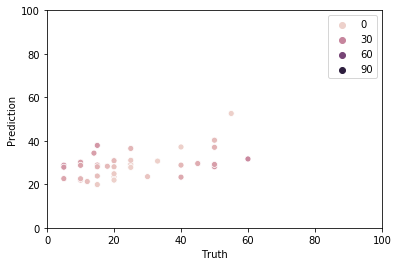

In [11]:
# Lasso
model_evaluation(model_lasso, 'LASSO')

model_name Performance:
	Mean absolute error: 12.68
	Mean squared error: 236.78
	Coefficient of determination: -0.02
	A  7.6 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 15.422155252884023


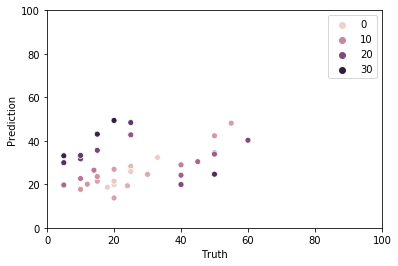

In [15]:
# Random Forest
model_evaluation(model_rfr, 'Random Forest Regression')

model_name Performance:
	Mean absolute error: 12.12
	Mean squared error: 204.01
	Coefficient of determination: 0.12
	A  11.700000000000001 percent change over the mean
	Average Change in Hourly Rate vs Naive Model: $ 15.375889497710785


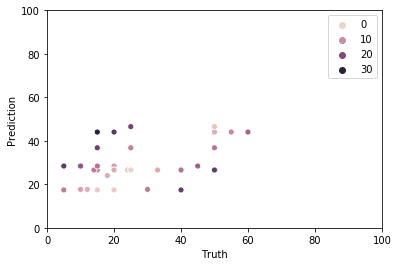

In [16]:
# AdaBoost
model_evaluation(model_ada, 'AdaBoosted Regression Trees')